In [1]:
import matplotlib.pyplot as plt
import numpy as np

Final position (NED): [  0.          45.25051813 350.1317512 ]
Final Euler angles: [43.1514054  0.         0.       ]


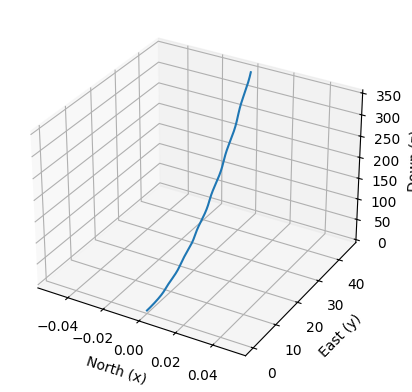

In [ ]:
class Quad3D_Euler_NED:
    def __init__(self, m=1.0, J=None, arm=0.2, kM=0.01, g=9.81):
        self.m = m
        self.J = np.diag([0.02, 0.02, 0.04]) if J is None else J
        self.Jinv = np.linalg.inv(self.J)
        self.arm = arm
        self.kM = kM
        self.g = g

    # ZYX Euler rotation matrix (body → NED)
    def rotation_matrix(self, phi, theta, psi):
        cφ, sφ = np.cos(phi), np.sin(phi)
        cθ, sθ = np.cos(theta), np.sin(theta)
        cψ, sψ = np.cos(psi), np.sin(psi)

        return np.array([
            [cψ*cθ, cψ*sθ*sφ - sψ*cφ, cψ*sθ*cφ + sψ*sφ],
            [sψ*cθ, sψ*sθ*sφ + cψ*cφ, sψ*sθ*cφ - cψ*sφ],
            [-sθ,   cθ*sφ,            cθ*cφ]
        ])

    def euler_rates(self, phi, theta, omega):
        p, q, r = omega
        cφ, sφ = np.cos(phi), np.sin(phi)
        cθ = np.cos(theta)
        tθ = np.tan(theta)

        eps = 1e-6
        if abs(cθ) < eps:
            cθ = np.sign(cθ)*eps if cθ != 0 else eps

        E = np.array([
            [1, sφ*tθ,  cφ*tθ],
            [0, cφ,     -sφ],
            [0, sφ/cθ,  cφ/cθ]
        ])
        return E @ omega

    def mixer(self, f):
        f1, f2, f3, f4 = f
        T = f1 + f2 + f3 + f4
        tau_x = self.arm * (f2 - f4)
        tau_y = self.arm * (f3 - f1)
        tau_z = self.kM  * (f1 - f2 + f3 - f4)
        return T, np.array([tau_x, tau_y, tau_z])

    def derivatives(self, x, f):

        pos = x[0:3]
        vel = x[3:6]
        phi, theta, psi = x[6:9]
        omega = x[9:12]

        R = self.rotation_matrix(phi, theta, psi)
        T, tau = self.mixer(f)

        # -----------------------------
        # NED Translational dynamics
        # -----------------------------
        thrust_world = R @ np.array([0, 0, -T])  # body z up → NED z down
        vdot = (1/self.m)*thrust_world + np.array([0,0,self.g])

        # Rotational dynamics
        omegadot = self.Jinv @ (tau - np.cross(omega, self.J @ omega))

        # Euler kinematics
        eulerdot = self.euler_rates(phi, theta, omega)

        xdot = np.zeros_like(x)
        xdot[0:3] = vel
        xdot[3:6] = vdot
        xdot[6:9] = eulerdot
        xdot[9:12] = omegadot

        return xdot

    def step(self, x, f, dt):
        k1 = self.derivatives(x, f)
        k2 = self.derivatives(x + 0.5*dt*k1, f)
        k3 = self.derivatives(x + 0.5*dt*k2, f)
        k4 = self.derivatives(x + dt*k3, f)
        return x + dt/6*(k1 + 2*k2 + 2*k3 + k4)


quad = Quad3D_Euler_NED(m=1.2, arm=0.18)

dt = 0.002
x = np.zeros(12)

# Hover condition in NED
T_hover = quad.m * quad.g
f_hover = np.array([T_hover/4]*4)

hist = []

for i in range(5000):
    t = i*dt
    f = f_hover.copy()

    # roll torque (1~3 sec)
    if 1.0 < t < 3.0:
        f[1] += 0.15
        f[3] -= 0.15

    x = quad.step(x, f, dt)
    hist.append(x.copy())

hist = np.array(hist)

print("Final position (NED):", hist[-1,0:3])
print("Final Euler angles:", hist[-1,6:9])

# 3D trajectory
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot3D(hist[:,0], hist[:,1], hist[:,2])
ax.set_xlabel("North (x)")
ax.set_ylabel("East (y)")
ax.set_zlabel("Down (z)")
plt.show()
